# Get plots for paper
This notebook creates the plots used in the research paper.

Change the current working directory to repo root.

In [1]:
import os
os.chdir("../.")
os.getcwd()

'/Users/lovhag/Documents/Projects/context-utilisation-for-RAG'

In [2]:
import pandas as pd
from scipy.stats import spearmanr
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import datasets

/Users/lovhag/Documents/Projects/context-utilisation-for-RAG/venv-plots/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Set configuration values 

In [3]:
ZERO_SHOT_PROMPT = False # whether to load the data checkpoint for the zero-shot prompt setting or not
DATA_NAMES = ["CounterFact", "ConflictQA", "DRUID"]
MODEL_NAMES = ["Llama", "Pythia"]

## Load data checkpoint

A data checkpoint with all of the context properties and model predictions should previously have been created in src/prepare_data.ipynb. Load it from the directory below, or use the Hugging Face datasets [checkpoint](https://huggingface.co/datasets/copenlu/reality-check-on-context-utilisation).

For the Hugging Face checkpoint, we need to specify the feature types or the data generator will fail:

In [4]:
features = datasets.Features({
    'id': datasets.Value('string'), 
    'claim': datasets.Value('string'),
    'evidence': datasets.Value('string'),
    'evidence_stance': datasets.Value('string'),
    'relevant': datasets.Value('string'),
    'factcheck_verdict': datasets.Value('string'),
    'claim_id': datasets.Value('string'),
    'implicit_rate_ner': datasets.Value('float64'),
    'flesch_reading_ease_score': datasets.Value('float64'),
    'uncertain_discourse_markers': datasets.Value('string'),
    'uncertain_hedge_terms': datasets.Value('string'),
    'uncertain_boosters_preceeded_by_negation': datasets.Value('string'),
    'claim_evidence_jaccard_sim': datasets.Value('float64'),
    'claim_repeated_in_evidence': datasets.Value('bool'),
    'evidence_length': datasets.Value('int32'),
    'claim_length': datasets.Value('int32'),
    'ppl_Llama': datasets.Value('float64'),
    'ppl_Pythia': datasets.Value('float64'),
    'p_True_claim_prompt': datasets.Value('float64'),
    'p__True_claim_prompt': datasets.Value('float64'),
    'p_False_claim_prompt': datasets.Value('float64'),
    'p__False_claim_prompt': datasets.Value('float64'),
    'p_None_claim_prompt': datasets.Value('float64'),
    'p__None_claim_prompt': datasets.Value('float64'),
    'p_Support_claim_prompt': datasets.Value('float64'),
    'p__Support_claim_prompt': datasets.Value('float64'),
    'p_Refute_claim_prompt': datasets.Value('float64'),
    'p__Refute_claim_prompt': datasets.Value('float64'),
    'p_True_evidence_prompt': datasets.Value('float64'),
    'p__True_evidence_prompt': datasets.Value('float64'),
    'p_False_evidence_prompt': datasets.Value('float64'),
    'p__False_evidence_prompt': datasets.Value('float64'),
    'p_None_evidence_prompt': datasets.Value('float64'),
    'p__None_evidence_prompt': datasets.Value('float64'),
    'p_Support_evidence_prompt': datasets.Value('float64'),
    'p__Support_evidence_prompt': datasets.Value('float64'),
    'p_Refute_evidence_prompt': datasets.Value('float64'),
    'p__Refute_evidence_prompt': datasets.Value('float64'),
    'claim_source': datasets.Value('string'),
    'factcheck_verdict_num': datasets.Value('float64'),
    'prediction_wo_evidence_claim_prompt_stance': datasets.Value('string'),
    'prediction_wo_evidence_claim_prompt_stance_num': datasets.Value('float64'),
    'prediction_w_evidence_evidence_prompt_stance': datasets.Value('string'),
    'prediction_w_evidence_evidence_prompt_stance_num': datasets.Value('float64'),
    'p_True_wo_evidence': datasets.Value('float64'),
    'p_False_wo_evidence': datasets.Value('float64'),
    'p_None_wo_evidence': datasets.Value('float64'),
    'p_True_w_evidence': datasets.Value('float64'),
    'p_False_w_evidence': datasets.Value('float64'),
    'p_None_w_evidence': datasets.Value('float64'),
    'dataset': datasets.Value('string'),
    'model': datasets.Value('string'),
    'evidence_source': datasets.Value('string'),
    'refers_external_source_cohere': datasets.Value('string'),
    'claimant': datasets.Value('string'),
    'claim_date': datasets.Value('string'),
    'evidence_date': datasets.Value('string'),
    'evidence_published_after_claim': datasets.Value('string'),
    'is_gold': datasets.Value('string'),
    'text': datasets.Value('string'),
    'is_factcheck_article': datasets.Value('string'),
    'unreliable_mbfc': datasets.Value('string'),
    'evidence_contains_true': datasets.Value('bool'),
    'evidence_contains_false': datasets.Value('bool'),
    'claim_published_before_train': datasets.Value('string'),
    'targeted_jaccard_sim': datasets.Value('float64'),
    'diff_p_None_scaled': datasets.Value('float64'),
    'diff_p_True_scaled': datasets.Value('float64'),
    'diff_p_False_scaled': datasets.Value('float64'),
    'memory_conflict': datasets.Value('string'),
    'pred_aligned_w_evidence': datasets.Value('string'),
    'pred_aligned_wo_evidence': datasets.Value('string'),
    'pred_switched': datasets.Value('string'),
    'pred_switched_to_align': datasets.Value('string')
})

In [5]:
# # load data from directory
# if ZERO_SHOT_PROMPT:
#     SAVE_DATA_FILE = "data/all_data_zero_shot.tsv"
# else:
#     SAVE_DATA_FILE = "data/all_data.tsv"
    
# data = pd.read_csv(SAVE_DATA_FILE, sep="\t")
    
# load data from checkpoint
if ZERO_SHOT_PROMPT:
    data = datasets.load_dataset("copenlu/reality-check-on-context-utilisation", "zero-shot", split="train", features=features)
else:
    data = datasets.load_dataset("copenlu/reality-check-on-context-utilisation", "few-shot", split="train", features=features)
# convert to pandas DataFrame
data = pd.DataFrame(data)
    
# fix None data types and set index
data = data.replace({np.nan: None}).set_index("id")

Fix type of boolean columns (formatted as strings by HuggingFace datasets)

In [6]:
data["refers_external_source_cohere"] = data["refers_external_source_cohere"].map({"True": True, "False": False})
data["unreliable_mbfc"] = data["unreliable_mbfc"].map({"True": True, "False": False})
data["uncertain_hedge_terms"] = data["uncertain_hedge_terms"].map({"True": True, "False": False})
data["uncertain_discourse_markers"] = data["uncertain_discourse_markers"].map({"True": True, "False": False})
data["is_factcheck_article"] = data["is_factcheck_article"].map({"True": True, "False": False})
data["is_gold"] = data["is_gold"].map({"True": True, "False": False})
data["evidence_published_after_claim"] = data["evidence_published_after_claim"].map({"True": True, "False": False})
data["memory_conflict"] = data["memory_conflict"].map({"True": True, "False": False})

## Set plot columns

Columns to investigate correlations with context utilization for

In [7]:
feature_cols = ['claim_evidence_jaccard_sim',
                'targeted_jaccard_sim',
                'claim_repeated_in_evidence',
                'flesch_reading_ease_score',
                'claim_length',
                'evidence_length',
                'ppl_Llama',
                'ppl_Pythia',
                'implicit_rate_ner',
                'refers_external_source_cohere',
                'unreliable_mbfc',
                'uncertain_hedge_terms',
                'uncertain_discourse_markers',
                'evidence_contains_true',
                'evidence_contains_false',
                'is_factcheck_article', 
                'is_gold',
                'evidence_published_after_claim', 
                'factcheck_verdict_num',
                'p_False_wo_evidence',
                'p_None_wo_evidence',
                'p_True_wo_evidence', 
                'memory_conflict',
                ]

feature_col_names = {'is_factcheck_article': 'Fact-check source', 
                     'evidence_published_after_claim': 'Pub. after claim', 
                     'is_gold': 'Gold source', 
                     'unreliable_mbfc': 'Unreliable source',
                     'factcheck_verdict_num': 'Fact-check verdict',
                     'implicit_rate_ner': 'Claim entity overlap', 
                     'claim_evidence_jaccard_sim': 'Jaccard similarity', 
                     'claim_repeated_in_evidence': 'Repeats claim', 
                     'evidence_contains_true': 'Contains "True"', 
                     'evidence_contains_false': 'Contains "False"',
                     'flesch_reading_ease_score': 'Flesch reading ease score', 
                     'ppl_Llama': 'Llama: Perplexity', 
                     'ppl_Pythia': 'Pythia: Perplexity',
                     'uncertain_discourse_markers': 'Contains hedging disc.', 
                     'uncertain_hedge_terms': 'Contains hedging',
                     'refers_external_source_cohere': 'Detection by LLM', 
                     'uncertain_cohere': 'Uncertain (Cohere)', 
                     'unreliable_cohere': 'Unreliable (Cohere)', 
                     'implicit_cohere': 'Implicit (Cohere)',
                     'evidence_length': 'Evidence length', 
                     'claim_length': 'Claim length',
                     'p_True_wo_evidence': '$P(\\mathrm{{True}}|C)$',
                     'p_False_wo_evidence': '$P(\\mathrm{{False}}|C)$',
                     'p_None_wo_evidence': '$P(\\mathrm{{None}}|C)$', 
                     'memory_conflict': 'Memory conflict',
                     'targeted_jaccard_sim': 'Claim-evidence overlap'}

# switch implicit_rate_ner to "claim entity overlap"
data["implicit_rate_ner"] = 1-data["implicit_rate_ner"]

# only include cols found in the dataset
feature_cols = [col for col in feature_cols if col in data.columns]

## Get characteristics plot

Fix DRUID/DRUID+ notation

In [8]:
DRUID_data = data[(data.dataset=="DRUID") & ~(data.evidence_stance.isna())].copy()
DRUID_data = DRUID_data.set_index(pd.Index([f"{ix}_DRUID" for ix in DRUID_data.index]))
data["dataset"] = data.dataset.replace({"DRUID": "DRUID+"})
data = pd.concat((data, DRUID_data))

Set context property (refers to external source) for CounterFact, for which we know that there never are references to external sources.

In [9]:
counterfact_ix = data[data.dataset=="CounterFact"].index
data.loc[counterfact_ix, "refers_external_source_cohere"] = False

Make the plot

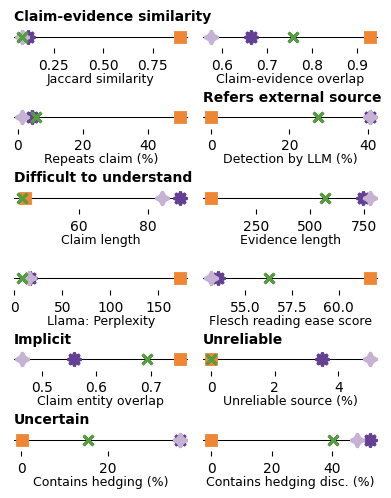

In [10]:
num_y_plots = 6
plot_cols = {(0,0): 'claim_evidence_jaccard_sim',
             (0,1): 'targeted_jaccard_sim',
             (1,0): 'claim_repeated_in_evidence',
             (2,0): 'claim_length',
             (2,1): 'evidence_length',
             (3,0): 'ppl_Llama',
             (3,1): 'flesch_reading_ease_score',
             (4,0): 'implicit_rate_ner',
             (4,1): 'unreliable_mbfc',
             (5,0): 'uncertain_hedge_terms',
             (5,1): 'uncertain_discourse_markers',
             (1,1): 'refers_external_source_cohere',
             }

percentage_cols = ['claim_repeated_in_evidence',
                   'refers_external_source_cohere',
                   'unreliable_mbfc',
                   'uncertain_hedge_terms',
                   'uncertain_discourse_markers']
perc_estimator = lambda x: sum(x)/len(x)*100

plot_titles = {(0,0): "Claim-evidence similarity",
               (2,0): "Difficult to understand",
               (4,0): "Implicit",
               (4,1): "Unreliable",
               (1,1): "Refers external source",
               (5,0): "Uncertain",
               }

hue_order = ["CounterFact", "DRUID", "DRUID+", "ConflictQA"]
colors_dict = {"CounterFact": '#EF8633', 
          "ConflictQA": '#559E3F', 
          "DRUID+": '#C6B3D4', 
          "DRUID": '#644095'}
colors = [colors_dict[v] for v in hue_order]
markers_dict = {"CounterFact": (4,0,45),
           "ConflictQA": (4,2,45), 
           "DRUID+": (4,1,0), 
           "DRUID": (8,1,0)}
markers = [markers_dict[v] for v in hue_order]

space_per_col = 0.42
# space_per_col = 1
f, axes = plt.subplots(num_y_plots, 2, figsize=(4,space_per_col*len(plot_cols)))
for ixs, col in plot_cols.items():
    # legend_setting = 'auto' if ixs==(0,1) else False
    legend_setting = False
    axes[ixs[0]][ixs[1]].hlines(y=0, xmin=-10, xmax=1000, color='black', linewidth=0.75)
    if col not in percentage_cols:
        sns.pointplot(data=data, x=col, hue="dataset", hue_order=hue_order, dodge=0, markersize=10, errorbar=None, palette=colors, markers=markers, ax=axes[ixs[0]][ixs[1]], legend=legend_setting, linestyle='')
        axes[ixs[0]][ixs[1]].set_xlabel(feature_col_names[col], labelpad=0, fontsize=9)
    else:
        sns.pointplot(data=data, estimator=perc_estimator, x=col, hue="dataset", hue_order=hue_order, dodge=0, markersize=10, errorbar=None, palette=colors, markers=markers, ax=axes[ixs[0]][ixs[1]], legend=legend_setting, linestyle='')
        axes[ixs[0]][ixs[1]].set_xlabel(feature_col_names[col]+" (%)", labelpad=0, fontsize=9)
        
    axes[ixs[0]][ixs[1]].set_yticks([])
    axes[ixs[0]][ixs[1]].set_ylim([-0.2,0.2])
    axes[ixs[0]][ixs[1]].spines[['left', 'right', 'top', 'bottom']].set_visible(False)
    if ixs in plot_titles:
        axes[ixs[0]][ixs[1]].set_title(plot_titles[ixs], loc='left', fontweight="bold", fontsize=10, y=0.85)
    # move legend outside
    if legend_setting=='auto':
        axes[ixs[0]][ixs[1]].legend(title="Dataset")
        # sns.move_legend(axes[ix], "upper left", bbox_to_anchor=(1, 1))
        sns.move_legend(axes[ixs[0]][ixs[1]], "lower center", bbox_to_anchor=(-0.2, 1), ncol=2, title=None, frameon=False)

f.tight_layout()
plt.subplots_adjust(hspace=2.5)
plt.savefig(f"figures/characteristics/all.pdf", bbox_inches='tight')
plt.show()

## Get aggregated model probabilities

In [11]:
agg_data = data.groupby(["dataset", "model"])[['p_False_wo_evidence', 'p_None_wo_evidence', 'p_True_wo_evidence']].agg(["mean", "std"])
agg_data

p_False_wo_evidence           p_None_wo_evidence  \
                                     mean       std               mean   
dataset     model                                                        
ConflictQA  Llama                0.376648  0.126897           0.093572   
            Llama-70B            0.422562  0.289212             0.1717   
            Mistral               0.33559  0.117483           0.226348   
            Pythia               0.411525  0.055826           0.062758   
CounterFact Llama                0.654153  0.111193           0.148224   
            Llama-70B            0.797355  0.128401           0.159839   
            Mistral              0.606019  0.163720           0.233574   
            Pythia               0.422361  0.064392           0.074915   
DRUID       Llama                0.506633  0.143297           0.237105   
            Llama-70B            0.543474  0.241383           0.230091   
            Mistral              0.541688  0.179921           0.208222   
            Pythia               0.461537  0.094325           0.041885   
DRUID+      Llama                0.504026  0.144943           0.235177   
            Llama-70B            0.539812  0.238752           0.230038   
            Mistral              0.538553  0.175277           0.207674   
            Pythia               0.449876  0.094732           0.040045   

                                p_True_wo_evidence            
                            std               mean       std  
dataset     model                                             
ConflictQA  Llama      0.040902           0.522544  0.152361  
            Llama-70B  0.107835           0.399533  0.321461  
            Mistral    0.092936           0.419452  0.169216  
            Pythia     0.034233           0.480914  0.067638  
CounterFact Llama      0.033875           0.191535  0.105867  
            Llama-70B  0.080296           0.036914  0.074527  
            Mistral    0.089816           0.145563  0.098508  
            Pythia     0.046914           0.456136  0.074487  
DRUID       Llama      0.059288           0.244134  0.151598  
            Llama-70B  0.081771           0.210269  0.213523  
            Mistral    0.085569           0.213709  0.178763  
            Pythia     0.025470           0.441051  0.112552  
DRUID+      Llama      0.060868           0.249117  0.155037  
            Llama-70B  0.082001           0.214464  0.214604  
            Mistral    0.085809           0.219091  0.175032  
            Pythia     0.025361           0.455978  0.115558

## Get context utilisation plot

Define the ACU metric (denoted "cu" for the dataframe)

In [12]:
DESIRED_CHANGES = {"refutes": {"diff_p_False_scaled": 1,
                               "diff_p_None_scaled": -1,
                               "diff_p_True_scaled": -1},
                   "supports": {"diff_p_False_scaled": -1,
                               "diff_p_None_scaled": -1,
                               "diff_p_True_scaled": 1},
                   "insufficient-neutral": {"diff_p_False_scaled": -1,
                               "diff_p_None_scaled": 1,
                               "diff_p_True_scaled": -1},
                   "insufficient-contradictory": {"diff_p_False_scaled": -1,
                               "diff_p_None_scaled": 1,
                               "diff_p_True_scaled": -1},
                   "insufficient-refutes": {"diff_p_False_scaled": 1,
                               "diff_p_None_scaled": 1,
                               "diff_p_True_scaled": -1},
                   "insufficient-supports": {"diff_p_False_scaled": -1,
                               "diff_p_None_scaled": 1,
                               "diff_p_True_scaled": 1},
                   "not_applicable": {"diff_p_False_scaled": -1,
                               "diff_p_None_scaled": 1,
                               "diff_p_True_scaled": -1}}

def get_agg_context_usage(row):
    if row.evidence_stance is None:
        return None
    agg_cu = 0
    for metric in ["diff_p_False_scaled", "diff_p_None_scaled", "diff_p_True_scaled"]:
        agg_cu += DESIRED_CHANGES[row.evidence_stance][metric]*row[metric]/3
    return agg_cu

Plot ACU across all samples for sufficient evidence

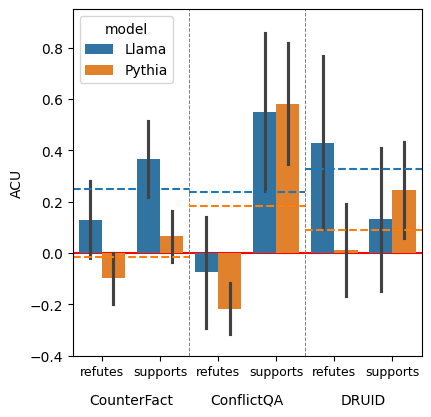

In [13]:
data["cu"] = data.apply(get_agg_context_usage, axis=1)
data["x"] = data.apply(lambda row: row.dataset+" "+row.evidence_stance if row.evidence_stance else row.dataset+" None", axis=1)
x_order = ['CounterFact refutes',
           'CounterFact supports',
           'ConflictQA refutes',
           'ConflictQA supports',
           'DRUID refutes',
           'DRUID supports']
ylim = [-0.4,0.95]

plt.figure(figsize=(4.5,4.5))
ax = sns.barplot(data=data[data.model.isin(MODEL_NAMES)], x="x", y="cu", hue="model", hue_order=MODEL_NAMES, errorbar="sd",
                 order=x_order)
xlim = ax.get_xlim()
ax.hlines(0, -1, 6, color="red", zorder=0)
[ax.axvline(x, color = 'grey', linestyle='--', linewidth=0.7) for x in [1.5,3.5]]

# add averaged ACU scores per dataset and model
dataset_xlims = {"CounterFact": [-0.5, 1.5], 
                 "ConflictQA": [1.5, 3.5], 
                 "DRUID": [3.5, 5.5]}
for dataset, xlims in dataset_xlims.items():
    for model in MODEL_NAMES:
        ax.hlines(data[(data.dataset==dataset) & \
                        (data.model==model) & \
                        (data.evidence_stance.isin(["supports", "refutes"]))].cu.mean(),
                   xlims[0],
                   xlims[1],
                   linestyle='--',
                   color="tab:blue" if model=="Llama" else "tab:orange")
        
ax.set_xlim(xlim)
ax.set_ylim(ylim)

locs, labels = plt.xticks()
plt.xticks(locs, ["refutes", "supports", "refutes", "supports", "refutes", "supports"], fontsize=9, rotation=0)
sec = ax.secondary_xaxis(location=0)
sec.set_xticks([0.5, 2.5, 4.5], labels=[f'\n\nCounterFact', f'\n\nConflictQA', f'\n\nDRUID'])
sec.tick_params('x', length=0)
sec.spines[['bottom']].set_visible(False)
plt.xlabel("")
plt.ylabel("ACU")

if ZERO_SHOT_PROMPT:
    plt.savefig(f"figures/context_usage/aggregated_zero_shot.pdf", bbox_inches='tight')
else:
    plt.savefig(f"figures/context_usage/aggregated.pdf", bbox_inches='tight')
plt.show()

**Zero-shot cu mean**

```python
model   dataset    
Llama   ConflictQA     0.564304
        CounterFact    0.572482
        DRUID          0.343839
Pythia  ConflictQA     0.498018
        CounterFact    0.322505
        DRUID          0.149094
```

**Few-shot cu mean**

In [14]:
data.groupby(["model", "dataset"]).cu.mean()

model      dataset    
Llama      ConflictQA     0.237131
           CounterFact    0.247929
           DRUID          0.280707
           DRUID+         0.280707
Llama-70B  ConflictQA     0.404193
           CounterFact    0.509464
           DRUID          0.321899
           DRUID+         0.321899
Mistral    ConflictQA     0.194329
           CounterFact    0.187669
           DRUID          0.267929
           DRUID+         0.267929
Pythia     ConflictQA     0.182760
           CounterFact   -0.016432
           DRUID          0.081932
           DRUID+         0.081932
Name: cu, dtype: float64

Plot ACU across all samples for insufficient evidence

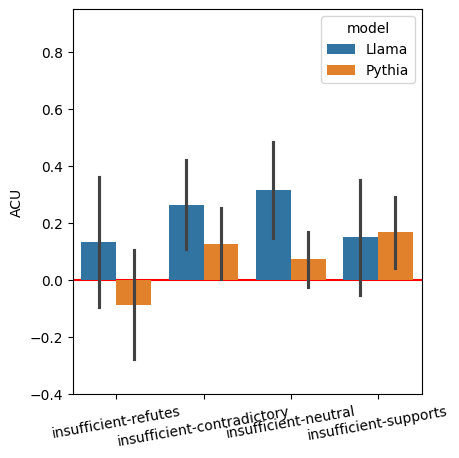

In [15]:
x_order = ['insufficient-refutes',
           'insufficient-contradictory',
           'insufficient-neutral',
           'insufficient-supports']

plt.figure(figsize=(4.5,5))
ax = sns.barplot(data=data[data.evidence_stance.isin(x_order) & data.model.isin(MODEL_NAMES)], x="evidence_stance", y="cu", hue="model", hue_order=MODEL_NAMES, errorbar="sd",
                 order=x_order)

xlim = ax.get_xlim()
ax.hlines(0, -1, 6, color="red", zorder=0)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.xticks(rotation=10)
plt.ylabel("ACU")
plt.xlabel("")

if ZERO_SHOT_PROMPT:
    plt.savefig(f"figures/context_usage/aggregated_insuff_zero_shot.pdf", bbox_inches='tight')
else:
    plt.savefig(f"figures/context_usage/aggregated_insuff.pdf", bbox_inches='tight')
plt.show()

## Plot correlations tables

### To scaled p diff

Model: Llama


/var/folders/3k/sg837cp921q0m6v8hdxlxrbwfb5x0c/T/ipykernel_45984/775549969.py:18: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  res = spearmanr(tmp_data[col], tmp_data[other_col].astype("float"), nan_policy='omit')
/var/folders/3k/sg837cp921q0m6v8hdxlxrbwfb5x0c/T/ipykernel_45984/775549969.py:18: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  res = spearmanr(tmp_data[col], tmp_data[other_col].astype("float"), nan_policy='omit')
/var/folders/3k/sg837cp921q0m6v8hdxlxrbwfb5x0c/T/ipykernel_45984/775549969.py:18: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  res = spearmanr(tmp_data[col], tmp_data[other_col].astype("float"), nan_policy='omit')
/var/folders/3k/sg837cp921q0m6v8hdxlxrbwfb5x0c/T/ipykernel_45984/775549969.py:18: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  res = spearmanr(tmp_data[co

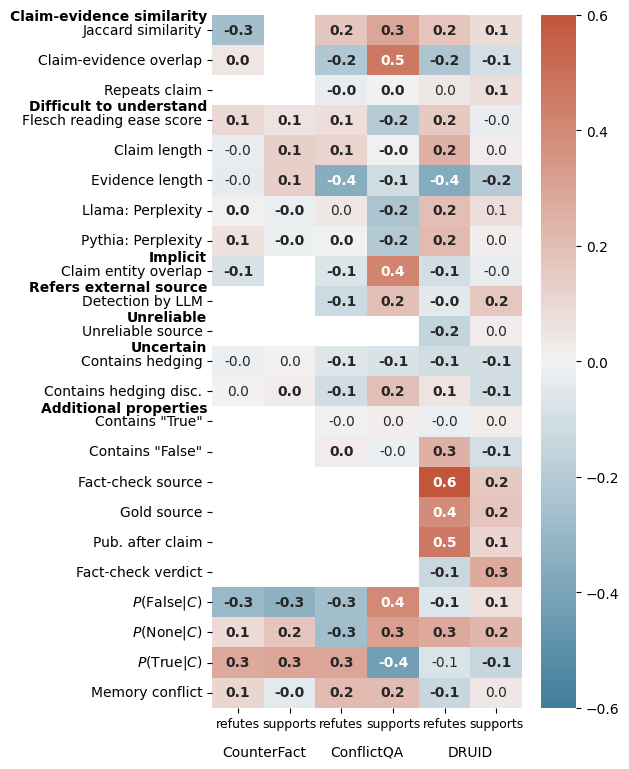

Model: Pythia


/var/folders/3k/sg837cp921q0m6v8hdxlxrbwfb5x0c/T/ipykernel_45984/775549969.py:18: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  res = spearmanr(tmp_data[col], tmp_data[other_col].astype("float"), nan_policy='omit')
/var/folders/3k/sg837cp921q0m6v8hdxlxrbwfb5x0c/T/ipykernel_45984/775549969.py:18: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  res = spearmanr(tmp_data[col], tmp_data[other_col].astype("float"), nan_policy='omit')
/var/folders/3k/sg837cp921q0m6v8hdxlxrbwfb5x0c/T/ipykernel_45984/775549969.py:18: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  res = spearmanr(tmp_data[col], tmp_data[other_col].astype("float"), nan_policy='omit')
/var/folders/3k/sg837cp921q0m6v8hdxlxrbwfb5x0c/T/ipykernel_45984/775549969.py:18: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  res = spearmanr(tmp_data[co

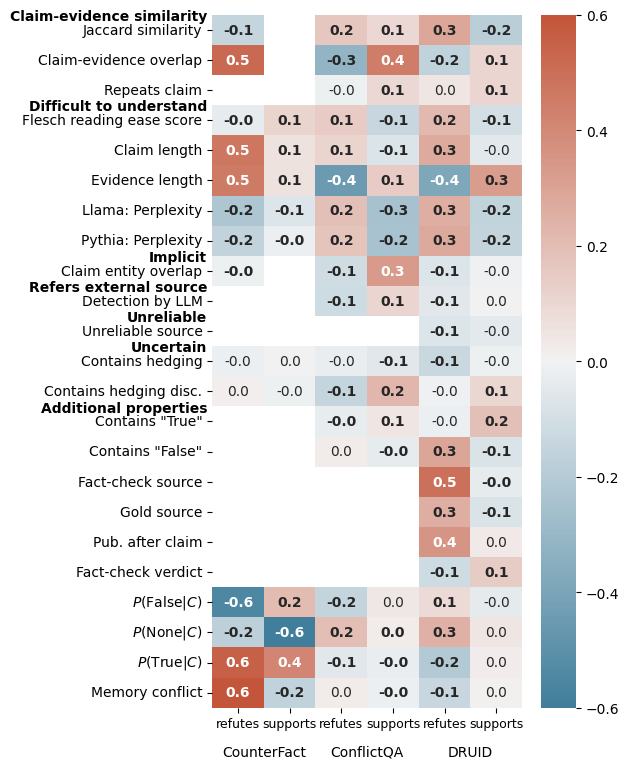

In [16]:
stances = ['refutes', 'supports']
col = "cu"
for model_name in MODEL_NAMES:
    print(f"Model: {model_name}")
    corr_data = {}
    significance_data = {}
    for d_name in DATA_NAMES:
        for stance in stances:
            if stance is not None and len(data[data.evidence_stance==stance]) > 0:
                tmp_data = data[(data.evidence_stance==stance) & (data.dataset==d_name) & (data.model==model_name)][[col] + feature_cols]

                # Compute the correlations
                col_name = stance+"\n"+d_name
                corr_data[col_name] = tmp_data.corr()[col].to_dict()
                # Compute the p values
                significance_entry = {}
                for other_col in corr_data[col_name].keys():
                    res = spearmanr(tmp_data[col], tmp_data[other_col].astype("float"), nan_policy='omit')
                    significance_entry[other_col] = res.pvalue
                significance_data[col_name] = significance_entry

    corr_data = pd.DataFrame(corr_data).T
    corr_data = corr_data.drop(columns=col).dropna(axis=1, how='all')
    corr_data = corr_data.rename(columns=feature_col_names)
    significance_data = pd.DataFrame(significance_data).T
    significance_data = significance_data.drop(columns=col).dropna(axis=1, how='all')
    significance_data = significance_data.rename(columns=feature_col_names)
    
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    plt.figure(figsize=(5,9))
    ax = sns.heatmap(data=corr_data.T[significance_data.T>=0.05], annot_kws={"fontstyle":"normal"}, cmap=cmap, vmax=.6, vmin=-.6, center=0, annot=True, fmt=".1f")
    sns.heatmap(data=corr_data.T[significance_data.T<0.05], annot_kws={"fontweight":"heavy"}, cmap=cmap, vmax=.6, vmin=-.6, center=0, annot=True, fmt=".1f", ax=ax, cbar=False)
    locs, labels = plt.xticks()
    plt.xticks(locs, [stances[0], stances[1], stances[0], stances[1], stances[0], stances[1]], fontsize=9, rotation=0)
    sec = ax.secondary_xaxis(location=0)
    sec.set_xticks([1, 3, 5], labels=[f'\n\n{DATA_NAMES[0]}', f'\n\n{DATA_NAMES[1]}', f'\n\n{DATA_NAMES[2]}'])
    sec.tick_params('x', length=0)
    sec.spines[['bottom']].set_visible(False)
    
    locs, labels = plt.yticks()
    sec_y = ax.secondary_yaxis(location=0)
    sec_y.set_yticks([0, 3, 8, 9, 10, 11, 13], labels=["Claim-evidence similarity", "Difficult to understand", "Implicit", "Refers external source", "Unreliable", "Uncertain", "Additional properties"], weight="bold")
    sec_y.tick_params('y', length=0, grid_color="white")
    sec_y.spines[['left']].set_visible(False)
    if ZERO_SHOT_PROMPT:
        plt.savefig(f"figures/correlations/p_{col}_{model_name}_zero_shot.pdf", bbox_inches='tight')
    else:
        plt.savefig(f"figures/correlations/p_{col}_{model_name}.pdf", bbox_inches='tight')
    plt.show()

For insufficient evidence from DRUID.

Model: Llama


/var/folders/3k/sg837cp921q0m6v8hdxlxrbwfb5x0c/T/ipykernel_45984/1851200526.py:18: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  res = spearmanr(tmp_data[col], tmp_data[other_col].astype("float"), nan_policy='omit')
/var/folders/3k/sg837cp921q0m6v8hdxlxrbwfb5x0c/T/ipykernel_45984/1851200526.py:18: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  res = spearmanr(tmp_data[col], tmp_data[other_col].astype("float"), nan_policy='omit')


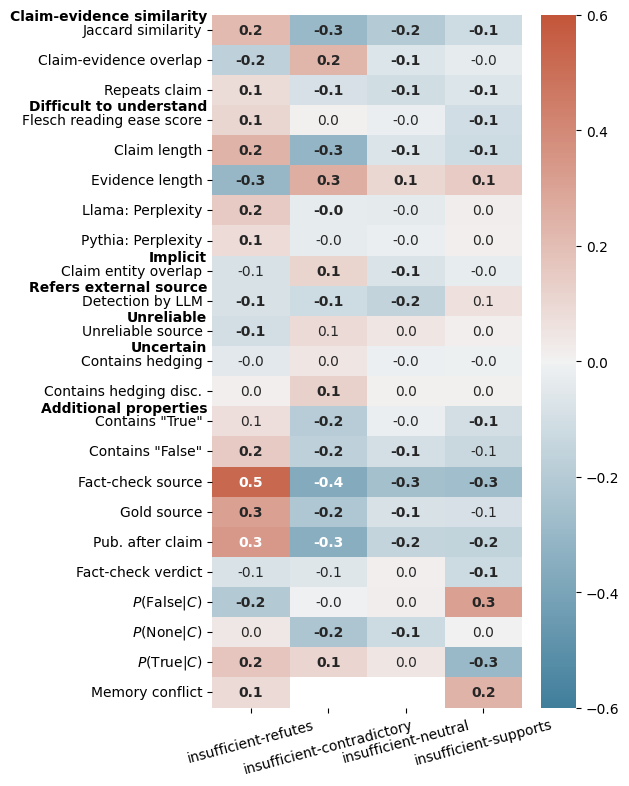

Model: Pythia


/var/folders/3k/sg837cp921q0m6v8hdxlxrbwfb5x0c/T/ipykernel_45984/1851200526.py:18: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  res = spearmanr(tmp_data[col], tmp_data[other_col].astype("float"), nan_policy='omit')
/var/folders/3k/sg837cp921q0m6v8hdxlxrbwfb5x0c/T/ipykernel_45984/1851200526.py:18: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  res = spearmanr(tmp_data[col], tmp_data[other_col].astype("float"), nan_policy='omit')


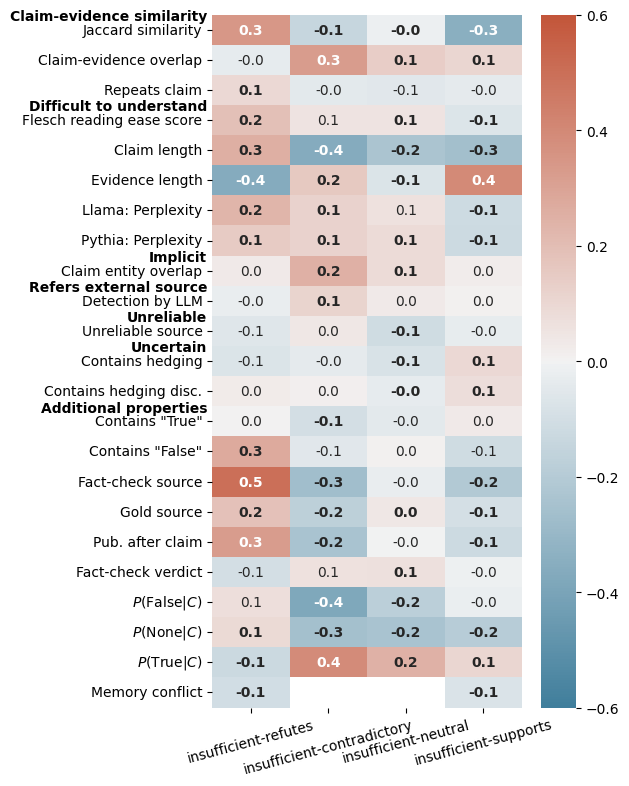

In [17]:
stances = ['insufficient-refutes', 'insufficient-contradictory', 'insufficient-neutral', 'insufficient-supports']
col = "cu"
d_name = "DRUID"
for model_name in MODEL_NAMES:
    print(f"Model: {model_name}")
    corr_data = {}
    significance_data = {}
    for stance in stances:
        if stance is not None and len(data[data.evidence_stance==stance]) > 0:
            tmp_data = data[(data.evidence_stance==stance) & (data.dataset==d_name) & (data.model==model_name)][[col] + feature_cols]

            # Compute the correlations
            col_name = stance
            corr_data[col_name] = tmp_data.corr()[col].to_dict()
            # Compute the p values
            significance_entry = {}
            for other_col in corr_data[col_name].keys():
                res = spearmanr(tmp_data[col], tmp_data[other_col].astype("float"), nan_policy='omit')
                significance_entry[other_col] = res.pvalue
            significance_data[col_name] = significance_entry

    corr_data = pd.DataFrame(corr_data).T
    corr_data = corr_data.drop(columns=col).dropna(axis=1, how='all')
    corr_data = corr_data.rename(columns=feature_col_names)
    significance_data = pd.DataFrame(significance_data).T
    significance_data = significance_data.drop(columns=col).dropna(axis=1, how='all')
    significance_data = significance_data.rename(columns=feature_col_names)
    
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    plt.figure(figsize=(5,9))
    ax = sns.heatmap(data=corr_data.T[significance_data.T>=0.05], annot_kws={"fontstyle":"normal"}, cmap=cmap, vmax=.6, vmin=-.6, center=0, annot=True, fmt=".1f")
    sns.heatmap(data=corr_data.T[significance_data.T<0.05], annot_kws={"fontweight":"heavy"}, cmap=cmap, vmax=.6, vmin=-.6, center=0, annot=True, fmt=".1f", ax=ax, cbar=False)
    plt.xticks(rotation=15)
    
    locs, labels = plt.yticks()
    sec_y = ax.secondary_yaxis(location=0)
    sec_y.set_yticks([0, 3, 8, 9, 10, 11, 13], labels=["Claim-evidence similarity", "Difficult to understand", "Implicit", "Refers external source", "Unreliable", "Uncertain", "Additional properties"], weight="bold")
    sec_y.tick_params('y', length=0, grid_color="white")
    sec_y.spines[['left']].set_visible(False)
    if ZERO_SHOT_PROMPT:
        plt.savefig(f"figures/correlations/p_{col}_{model_name}_insuff_zero_shot.pdf", bbox_inches='tight')
    else:
        plt.savefig(f"figures/correlations/p_{col}_{model_name}_insuff.pdf", bbox_inches='tight')
    plt.show()

## Examples

- For each dataset, model, stance and cu case (2 examples)
- High context usage: cu>1.5
- Low context usage: 0 < cu < 0.5
- Anti-context usage: cu < -0.5

In [18]:
def print_sample(sample_ix, data):
    s = data.loc[sample_ix]
    tab_sample = {"\\textbf{Dataset}": s.dataset,
                  "\\textbf{Claim}": s.claim,
                  "\\textbf{Evidence}": s.evidence,
                  "\\textbf{Evidence stance}": s.evidence_stance}
    def get_probs(s):
        tab_sample[f"$\\bm{{\\mathrm{{ACU}}_{{\\mathrm{{{s.model}}}}}}}$"] = f"{s.cu:.2f}"
        for t in ["False", "None", "True"]:
            p_val = s[f"p_{t}_wo_evidence"]
            tab_sample[f"$P_{{\\mathrm{{{s.model}}}}}(\mathrm{{{t}}}|C)$"] = f"{p_val:.2f}"
            p_val = s[f"p_{t}_w_evidence"]
            tab_sample[f"$P_{{\\mathrm{{{s.model}}}}}(\mathrm{{{t}}}|C, E)$"] = f"{p_val:.2f}"
    get_probs(s)
        
    # add other model preds for same samples
    if s.model == "Pythia":
        other_model = "Llama"
    else:
        other_model = "Pythia"
        
    other_model_ix = ix.replace(s.model, other_model)
    s = data.loc[other_model_ix]
    get_probs(s)
    print(pd.Series(tab_sample).to_latex())
    print()

n_samples = 1
for d_set in ["CounterFact", "ConflictQA", "DRUID"]:
    for model in ["Llama", "Pythia"]:
        for stance in ["refutes", "insufficient-neutral", "supports"]:
            tmp_data = data[(data.dataset==d_set) & (data.model==model) & (data.evidence_stance==stance)]
            if len(tmp_data) > 0:
                lb_cu = 1
                print("--------------------------")
                print(f"{lb_cu} < cu")
                try:
                    samples_ix = tmp_data[(tmp_data.cu>lb_cu)].sample(n_samples, random_state=41).index.tolist()
                    for ix in samples_ix:
                        print_sample(ix, data)
                except ValueError as e:
                    print(f"Error when printing sample for {model}, {d_set} and {stance}")
                    print(e)
                    
                print("--------------------------")
                lb_cu = 0
                ub_cu = 0.5
                print(f"{lb_cu} < cu < {ub_cu}")
                try:
                    samples_ix = tmp_data[(tmp_data.cu>lb_cu) & (tmp_data.cu<ub_cu)].sample(n_samples, random_state=42).index.tolist()
                    for ix in samples_ix:
                        print_sample(ix, data)
                except ValueError as e:
                    print(f"Error when printing sample for {model}, {d_set} and {stance}")
                    print(e)
                    
                print("--------------------------")
                ub_cu = -0.5
                print(f"cu < {ub_cu}")
                try:
                    samples_ix = tmp_data[(tmp_data.cu<ub_cu)].sample(n_samples, random_state=43).index.tolist()
                    for ix in samples_ix:
                        print_sample(ix, data)
                except ValueError as e:
                    print(f"Error when printing sample for {model}, {d_set} and {stance}")
                    print(e)

--------------------------
1 < cu
Error when printing sample for Llama, CounterFact and refutes
a must be greater than 0 unless no samples are taken
--------------------------
0 < cu < 0.5
\begin{tabular}{ll}
\toprule
 & 0 \\
\midrule
\textbf{Dataset} & CounterFact \\
\textbf{Claim} & Transit New Zealand, whose headquarters are in Rochester. \\
\textbf{Evidence} & Transit New Zealand, whose headquarters are in Wellington. \\
\textbf{Evidence stance} & refutes \\
$\bm{\mathrm{ACU}_{\mathrm{Llama}}}$ & 0.00 \\
$P_{\mathrm{Llama}}(\mathrm{False}|C)$ & 0.72 \\
$P_{\mathrm{Llama}}(\mathrm{False}|C, E)$ & 0.45 \\
$P_{\mathrm{Llama}}(\mathrm{None}|C)$ & 0.15 \\
$P_{\mathrm{Llama}}(\mathrm{None}|C, E)$ & 0.53 \\
$P_{\mathrm{Llama}}(\mathrm{True}|C)$ & 0.12 \\
$P_{\mathrm{Llama}}(\mathrm{True}|C, E)$ & 0.02 \\
$\bm{\mathrm{ACU}_{\mathrm{Pythia}}}$ & -0.08 \\
$P_{\mathrm{Pythia}}(\mathrm{False}|C)$ & 0.28 \\
$P_{\mathrm{Pythia}}(\mathrm{False}|C, E)$ & 0.21 \\
$P_{\mathrm{Pythia}}(\mathrm{None}|